### 신경망 시작하기
이번 Post에서는 크게 **1) 영화 리부 분류(이진 분류 문제) 2) 뉴스 기사 분류(다중 분류 문제) 3) 주택 가격 예측(회귀 문제)** 를 다룬다.  

1, 2의 문제 같은경우 Text를 기반으로 분류 문제를 실시한다.(NLP)  
이에 관하여 알아두면 좋은 Post는 아래 링크를 참조하자.  
1. <a href="https://wjddyd66.github.io/dl/%EC%9E%90%EC%97%B0%EC%96%B4%EC%99%80-%EB%8B%A8%EC%96%B4%EC%9D%98-%EB%B6%84%EC%82%B0-%ED%91%9C%ED%98%84/">자연어와 단어의 분산 표현</a>
2. <a href="https://wjddyd66.github.io/dl/KoNLPy/">KoNLPy</a>
3. <a href="https://wjddyd66.github.io/dl/word2vec/">word2vec</a>
4. <a href="https://wjddyd66.github.io/dl/Fast-word2vec/">Fast word2vec</a>

<br>
3의 문제에 대하여 미리 알아두면 좋은 Post는 아래 링크를 참조하자.
1. <a href="https://wjddyd66.github.io/r/Classfication/">R-분류분석</a>

처음 Post에서도 언급하였듯이 자세한 수식이나 원리에 대해서는 미리 Post한 곳을 참조하고 Keras Category에서는 최대한 Keras 사용법에 집중한다.

<br><br>
#### 필요한 라이브러리 Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

from keras.datasets import imdb
from keras.datasets import reuters
from keras.datasets import boston_housing

### 영화 리뷰 분류(이진 분류 예제)

#### IMDB 데이터셋 다운로드
Keras에서 지원하는 <code>kereas.datasets</code>중에서 영화 리뷰 분류를 위하여 imdb Dataset을 활용한다.  
imdb Dataset은 인터넷 영화 데이터베이스로부터 가져온 양그단의 리뷰 5만 개로 이루어진 데이터 셋이다.  
<code>imdb.load_data(num_words=10000)</code>으로서 Word의 개수를 10000개로 제한한다. 즉, 많이 사용하는 단어 10000개만을 사용한다는 뜻이다.  
이렇게 되면 **Vocab의 개수는 10000개로서 정의된다.**  
- train_data: Vocab 의 Index로서 표현된 Data이다.
- train_labels: 0: 부정, 1: 긍정


In [70]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)
print(train_data[0]) # Train Data 확인
print(train_labels[0]) # Train Label 확인
print(max([max(sequence) for sequence in train_data])) #Vocab 최대 Index 확인

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
9999


#### 데이터셋 변환
Dataset을 여기서는 One-hot Vector로서 Encoding을 실시한다.  
즉 Train_Data를 10000 Dimension의 Zero Vector로 만든 뒤 단어가 존재하는 Index만을 1로서 표현한다.

In [71]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print(x_train[0])
print(x_train.shape)

[0. 1. 1. ... 0. 0. 0.]
(25000, 10000)


#### Model만들기
Input_shape는 One-hot Vector의 Dimension인 10000으로 정의  
Model중간에 Layers를 추가하는 것은 그저 비선형을 증가시키기 위한 과정  
Model 마지막 output은 0 or 1로서 표현해야 하므로 Activation Function을 Sigmoid로 선언

In [72]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_50 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None


#### Compile 설정
- Optimizer: rmsprop
- Loss Function: binary_crossentropy(0 or 1로서 Classification하므로)
- metrics: 정확도에 대해서 Monitoring


In [73]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

#### Validation Dataset
훈련 검증을 위하여 Validation Dataset을 준비

In [74]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

#### Trainning
Trainning의 결과(<code>model.fit()</code>)를 하나의 객체로서 반환할 수 있다.  
**History는 Trainning에서 발생한 모든 정보를 Dictionary 형태로서 가지고 있다.**  
또하나의 **Keras의 매력적인 점은 Validation Data를 <code>model.fit()</code>에 Parameter로서 넣어서 따로 Validation과정을 거치지 않아도 된다는 것이다.**

In [75]:
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 1s 85us/step - loss: 0.5425 - accuracy: 0.7787 - val_loss: 0.4426 - val_accuracy: 0.8304
Epoch 2/20
15000/15000 [==============================] - 1s 57us/step - loss: 0.3420 - accuracy: 0.8961 - val_loss: 0.3306 - val_accuracy: 0.8812
Epoch 3/20
15000/15000 [==============================] - 1s 55us/step - loss: 0.2504 - accuracy: 0.9221 - val_loss: 0.2956 - val_accuracy: 0.8832
Epoch 4/20
15000/15000 [==============================] - 1s 46us/step - loss: 0.1961 - accuracy: 0.9381 - val_loss: 0.2792 - val_accuracy: 0.8895
Epoch 5/20
15000/15000 [==============================] - 1s 44us/step - loss: 0.1586 - accuracy: 0.9488 - val_loss: 0.3168 - val_accuracy: 0.8745
Epoch 6/20
15000/15000 [==============================] - 1s 50us/step - loss: 0.1296 - accuracy: 0.9595 - val_loss: 0.3011 - val_accuracy: 0.8821
Epoch 7/20
15000/15000 [==============================] - 1s 53us/st

#### Trainning & Validation Loss Visualization
history(<code>model.fit()</code>의 결과)를 활용하여서 Loss를 Visualization하는 과정이다.
matplotlib을 사용하므로 matplotlib에 대해서 사전지식이 없으면 아래 링크를 참조하다.  
<a href="https://wjddyd66.github.io/dataanalysis/Matplotlib/">Matplotlib</a>

['loss', 'val_accuracy', 'val_loss', 'accuracy']


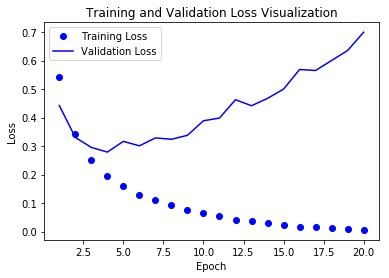

In [76]:
history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Trainning & Validation Accuracy Visualization

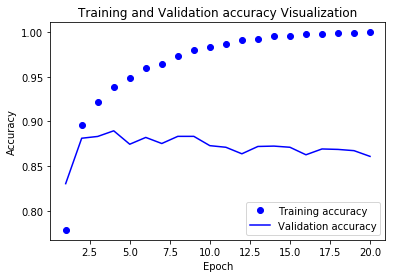

In [77]:
plt.clf() # 그래프를 초기화
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epoch = range(1,len(loss)+1)

plt.plot(epoch,accuracy,'bo',label='Training accuracy')
plt.plot(epoch,val_accuracy,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**위의 결과로서 Training의 Accuracy는 증가 되고 Loss는 줄어드는 것을 확인 할 수 있지만 Validation의 결과는 반대인 것을 알 수 있다. 이것으로 인하여 Overfitting이 일어났다는 것을 알 수 있다.**  

#### Model ReTrainning & Test
Visualization결과 Epoch가 5이상부터 급격하게 Overfitting일 일어나는 것을 확인하였으므로 Epoch를 4로 설정한뒤 Training을 다시 한다.  
또한 Training된 Model을 알아보는 2가지 방법또한 알아보자.
- <code>model.evaluate(x_text,y_test)</code>: Input, Label을 Parameter로서 주어지면 Return을 [Loss,Accuracy]로서 Training된 Model의 결과를 출력한다. Input과 그에대한 **Output을 알아야 하므로 Test Data를 평가할 때 사용한다.**
- <code>model.evaluate(x_text)</code>: Input을 Parameter로서 주어지면 Return을 Label로서 Training되 Model의 결과를 출력한다. **Label을 알아내는 것이므로 새로운 Data가 평가할 때 사용한다.**


In [9]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=4,batch_size=512,validation_data=(x_val,y_val))

result = model.evaluate(x_test,y_test)
print(result)
print(model.predict(x_test))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 1s 75us/step - loss: 0.5326 - accuracy: 0.7777 - val_loss: 0.4306 - val_accuracy: 0.8305
Epoch 2/4
15000/15000 [==============================] - 1s 62us/step - loss: 0.3189 - accuracy: 0.8989 - val_loss: 0.3341 - val_accuracy: 0.8716
Epoch 3/4
15000/15000 [==============================] - 1s 51us/step - loss: 0.2348 - accuracy: 0.9221 - val_loss: 0.3022 - val_accuracy: 0.8780
Epoch 4/4
25000/25000 [==============================] - 1s 56us/step
[0.2919962071228027, 0.8827599883079529]
[[0.2258622 ]
 [0.99946165]
 [0.9022805 ]
 ...
 [0.16248763]
 [0.14325649]
 [0.495635  ]]


### 뉴스 기사 분류(다중 분류 예제)

#### 로이터 데이터셋 다운로드
Keras에서 지원하는 <code>kereas.datasets</code>중에서 뉴스 기사 분류를 위하여 reuters Dataset을 활용한다.  
reuters Dataset은 뉴스 기사와 토픽의 집합으로서 46개의 토픽(Label)과 기사로서 이루워져있다.  
<code>reuters.load_data(num_words=10000)</code>으로서 Word의 개수를 10000개로 제한한다. 즉, 많이 사용하는 단어 10000개만을 사용한다는 뜻이다.  

In [10]:
(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)
print(train_data[0]) # Train Data 확인
print(train_labels[0]) # Train Label 확인
print(max([max(sequence) for sequence in train_data])) #Vocab 최대 Index 확인

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
9999


#### 데이서 준비
이전에 사용한 Dataset과 동일하게 Ont-Hot-Encoding로서 변환한다.  
Label 또한 0 or 1이 아닌 46개의 Class이므로 One-Hot-Encoding을 적용한다.

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = vectorize_sequences(train_labels,dimension=46)
y_test = vectorize_sequences(test_labels,dimension=46)

#### Model 구성
이전 **영화 리뷰 분류(이진 분류 예제)**와 동일하지만 다른 구성은 마지막의 Output이다.  
기존에는 1 or 0 즉, 긍정 부정만으로서 나누었지만 **뉴스 기사 분류(다중 분류 예제)**는 46개의 토픽에 관하여 Classification을 하므로 Output 단의 Activation Function을 Softmax를 사용하고 Class를 46개로 지정한다.

In [12]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________
None


#### Compile 정의
이전 Compile과 동일하지만 달리진점은 Loss Function이다.  
이전에는 이진분류로서 **binary_crossentropy**를 사용하였지만 다중분류를 위해서 **categorical_crossentropy**를 사용한다.

In [13]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

#### Validation Dataset 만들기

In [19]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

#### Training

In [20]:
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 68us/step - loss: 2.5209 - accuracy: 0.4990 - val_loss: 1.6840 - val_accuracy: 0.6520
Epoch 2/20
7982/7982 [==============================] - 0s 47us/step - loss: 1.3914 - accuracy: 0.7117 - val_loss: 1.2994 - val_accuracy: 0.7290
Epoch 3/20
7982/7982 [==============================] - 0s 44us/step - loss: 1.0409 - accuracy: 0.7790 - val_loss: 1.1422 - val_accuracy: 0.7400
Epoch 4/20
7982/7982 [==============================] - 0s 44us/step - loss: 0.8250 - accuracy: 0.8235 - val_loss: 1.0381 - val_accuracy: 0.7880
Epoch 5/20
7982/7982 [==============================] - 0s 44us/step - loss: 0.6602 - accuracy: 0.8632 - val_loss: 0.9918 - val_accuracy: 0.7870
Epoch 6/20
7982/7982 [==============================] - 0s 45us/step - loss: 0.5319 - accuracy: 0.8890 - val_loss: 0.9387 - val_accuracy: 0.8140
Epoch 7/20
7982/7982 [==============================] - 0s 45us/step - loss: 0.426

#### Trainning & Validation Loss Visualization
history(<code>model.fit()</code>의 결과)를 활용하여서 Loss를 Visualization하는 과정이다.

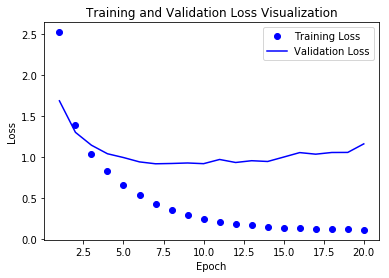

In [21]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch,loss,'bo',label='Training Loss')
plt.plot(epoch,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss Visualization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Trainning & Validation Accuracy Visualization

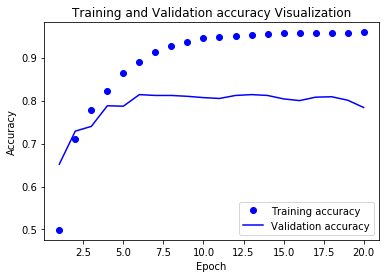

In [23]:
plt.clf() # 그래프를 초기화
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epoch = range(1,len(loss)+1)

plt.plot(epoch,accuracy,'bo',label='Training accuracy')
plt.plot(epoch,val_accuracy,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy Visualization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Model ReTrainning & Test
Visualization결과 Epoch가 9이상부터 급격하게 Validation의 결과과 변하지 않는 것을 알 수 있다.  
따라서 Epoch를 9로서 다시 Model을 선언하고 결과를 확인하자.

In [26]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(partial_x_train,partial_y_train,epochs=9,batch_size=512,validation_data=(x_val,y_val))

result = model.evaluate(x_test,y_test)
print(result)
predict = model.predict(x_test)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 0s 57us/step - loss: 2.5845 - accuracy: 0.5080 - val_loss: 1.7111 - val_accuracy: 0.6270
Epoch 2/9
7982/7982 [==============================] - 0s 45us/step - loss: 1.4115 - accuracy: 0.6966 - val_loss: 1.3203 - val_accuracy: 0.6980
Epoch 3/9
7982/7982 [==============================] - 0s 40us/step - loss: 1.0420 - accuracy: 0.7750 - val_loss: 1.1302 - val_accuracy: 0.7560
Epoch 4/9
7982/7982 [==============================] - 0s 33us/step - loss: 0.8122 - accuracy: 0.8269 - val_loss: 1.0510 - val_accuracy: 0.7730
Epoch 5/9
7982/7982 [==============================] - 0s 45us/step - loss: 0.6435 - accuracy: 0.8675 - val_loss: 0.9639 - val_accuracy: 0.8100
Epoch 6/9
7982/7982 [==============================] - 0s 43us/step - loss: 0.5093 - accuracy: 0.8940 - val_loss: 0.9963 - val_accuracy: 0.7700
Epoch 7/9
7982/7982 [==============================] - 0s 45us/step - loss: 0.4069 - acc

#### 참조사항(Softmax 결과 확인)
Softmax의 결과로서 Index의 모든 합이 1에 가까운 것을 알 수 있다.  
또한 제대로된 Label을 알기위해서는 <code>np.argmax()</code>를 사용하여야 한다.  
Softmax에 대한 자세한 내용은 아래 링크를 참조하자.  
<a href="https://wjddyd66.github.io/dl/NeuralNetwork-(1)-Basic-&-Activation-Function/">Softmax</a>

In [29]:
print(np.argmax(predict[1]))
print(np.sum(predict[1]))

1
0.99999994


### 주택 가격 예측: 회귀 문제
앞의 두개의 Model은 Classification의 문제였다.  
**회귀 문제는 개별적인 Label이 어디에 속하는 Classification이 아니라 연속적인 값을 예측하는 것 이다.**  

#### 보스턴 주택 가격 데이터셋 다운로드
Keras에서 지원하는 <code>kereas.datasets</code>중에서 보스턴 주택 가격 예측을 위하여 boston_housing Dataset을 활용한다.  
boston_housing Dataset은 Train: 404, Test: 102개의 데이터셋으로 구성되어있고 Feature의 개수는 13개이다.

In [40]:
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()
print(train_data[0]) # Train Data 확인
print(train_targets[0]) # Train Targets 확인
print(len(train_data[0])) #Train Data Feature 개수 확인

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2
13


#### 데이터셋 준비
대부분의 Dataset을 준비하는 과정에서 제일 중요한 것은 **정규화**이다.  
이전 두개의 Model의 Data는 Text로서 One-Hot-Vector로서 나타내었다.  
하지만 **booston_housin의 Dataset은 13개의 Feature를 가지고 있고 이러한 Feature의 범위가 전부 다르다. 즉 이러한 Dataset의 Feature를 정규화를 시켜야 하는 과정을 거쳐야한다.**  
**또한 중요한점은 TestDataset의 정규화는 TestDataset이 기준이 아니라 TrainDataset기준으로 정규화를 시켜야 한다는 것 이다. 다른 새로운 Dataset이 들어와 Model에 적용시키기전에 또한 정규화를 TrainDataset기준으로 하여야 한다.**

In [32]:
mean = train_data.mean(axis=0)
train_data -=mean
std = train_data.std(axis=0)
train_data /= std

test_data -=mean
test_data /=std

#### Model구성
이전 두 Model과 다른점은 Loss Function을 MSE를 사용한다.  
Metrics를 MAE를 사용한다.  
**MAE(Mean Absolute Error, MAE)는 평균절대 오차를 의미한다.** 기준에 따라다르지만 MAE가 0.5면 예측이 평균적으로 500달러 정도 차이가 난다는 뜻이다.  
또한 Model을 여러번 사용하기 때문에 하나의 Method로서 선언한다.  
이번 Model에서의 MAE의 의미를 알기 위해서는 Dataset의 Label을 알아야 한다.  
Label의 값은 1.2, 7.2 ... 의 값으로 이루워져있고 이것의 의미는 1200달러, 7200달러를 의미한다.  
즉 MAE의 값이 0.5면 500달러 정도의 오차를 의미한다고 할 수 있다.  

In [38]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    
    return model

#### K-fold cross-validation

<img src="https://www.researchgate.net/profile/B_Aksasse/publication/326866871/figure/fig2/AS:669601385947145@1536656819574/K-fold-cross-validation-In-addition-we-outline-an-overview-of-the-different-metrics-used.jpg" height="300" width="600">

K개의 fold를 만들어서 진행하는 교차 검증  
**사용 이유**  
- 총 데이터 갯수가 적은 데이터 셋에 대하여 정확도를 향상시킬 수 있음
- 기존에 Training, Validation, Test 세 개의 집단으로 분류하는 것보다, Training과 Test로만 분류할 때 학습 데이터 셋이 더 많기 때문이다.
- 데이터 수가 적은데 검증과 테스트에 데이터를 사용하면 Underfitting 등 성능이 미달되는 모델이 학습됨


In [58]:
k = 4
num_val_samples = len(train_data)//k
num_epoch = 500
all_mae_history = []

for i in range(k):
    print('Fold #',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_target = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate(
    [train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data = (val_data,val_target),
                        epochs=num_epoch,batch_size=1,verbose=0) # verbose=0이면 Model Trainning과정이 출력되지 않는다.
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

('Fold #', 0)
('Fold #', 1)
('Fold #', 2)
('Fold #', 3)


#### 결과 확인
Smooth한 곡선의 결과를 얻기 위하여 다음과 같은 과정을 거친다.
1. Fold = 4 로서 4번진행한 MAE에 대하영 각각의 평균을 구한다.
2. 지수 이동 평균으로서 smoothed_points를 표현한다. 지수 이동 평균이란 이전에 계산된 이동평균에 factor를 곱하고 현재 포인트에 (1-factor)를 곱하여 나타낸 것을 의미한다. factor의 값을 0.9를 주어 이전에 값에 좀 더 많은 가중치를 두어서 값의 변화가 Smooth하게 변할 것이라는 것을 예측할 수 있다.
3. Smooth한 곡선을 얻기위하여 아직 Training이 잘 되지않은 처음 10개의 Data는 제외한다.

**결과를 확인하면 3200달러 정도가 차이나는 것을 확인할 수 있다.**

102/102 [==============================] - 0s 50us/step
('Test_Mae_Score', 3.21199893951416)


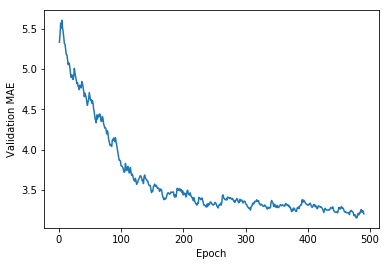

In [68]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epoch)]
test_mse_score,test_mae_score = model.evaluate(test_data,test_targets)
print('Test_Mae_Score',test_mae_score)

def smooth_curve(points,factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.show()